In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss

# Depthwise Separable Convolution
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

# Define MobileNet
class MobileNet(nn.Module):
    def __init__(self, num_classes=25):
        super(MobileNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            DepthwiseSeparableConv(32, 64, stride=1),
            DepthwiseSeparableConv(64, 128, stride=2),
            DepthwiseSeparableConv(128, 128, stride=1),
            DepthwiseSeparableConv(128, 256, stride=2),
            DepthwiseSeparableConv(256, 256, stride=1),
            DepthwiseSeparableConv(256, 512, stride=2),

            DepthwiseSeparableConv(512, 512, stride=1),
            DepthwiseSeparableConv(512, 512, stride=1),
            DepthwiseSeparableConv(512, 512, stride=1),
            DepthwiseSeparableConv(512, 512, stride=1),
            DepthwiseSeparableConv(512, 512, stride=1),

            DepthwiseSeparableConv(512, 1024, stride=2),
            DepthwiseSeparableConv(1024, 1024, stride=1),

            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Define test transformations
transform = transforms.Compose([
    transforms.Resize((416, 416)),
    # # transforms.RandomResizedCrop(416), 
    transforms.RandomHorizontalFlip(), 
    transforms.RandomVerticalFlip(),   
    transforms.RandomRotation(10),     
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load test data
test_dataset = ImageFolder(root=r'C:\Users\sshak\Downloads\Seen Datasets2\Seen Datasets\val', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Load the saved model
model = MobileNet(num_classes=25).cuda()
model.load_state_dict(torch.load('model.pth'))
model = model.cuda()



100%|██████████| 235/235 [02:37<00:00,  1.49it/s]


Test Accuracy: 0.84%
Test Precision: 0.84
Test Recall: 0.84
Test F1 Score: 0.84
Test ROC-AUC: 0.99
Test Log Loss: 0.65


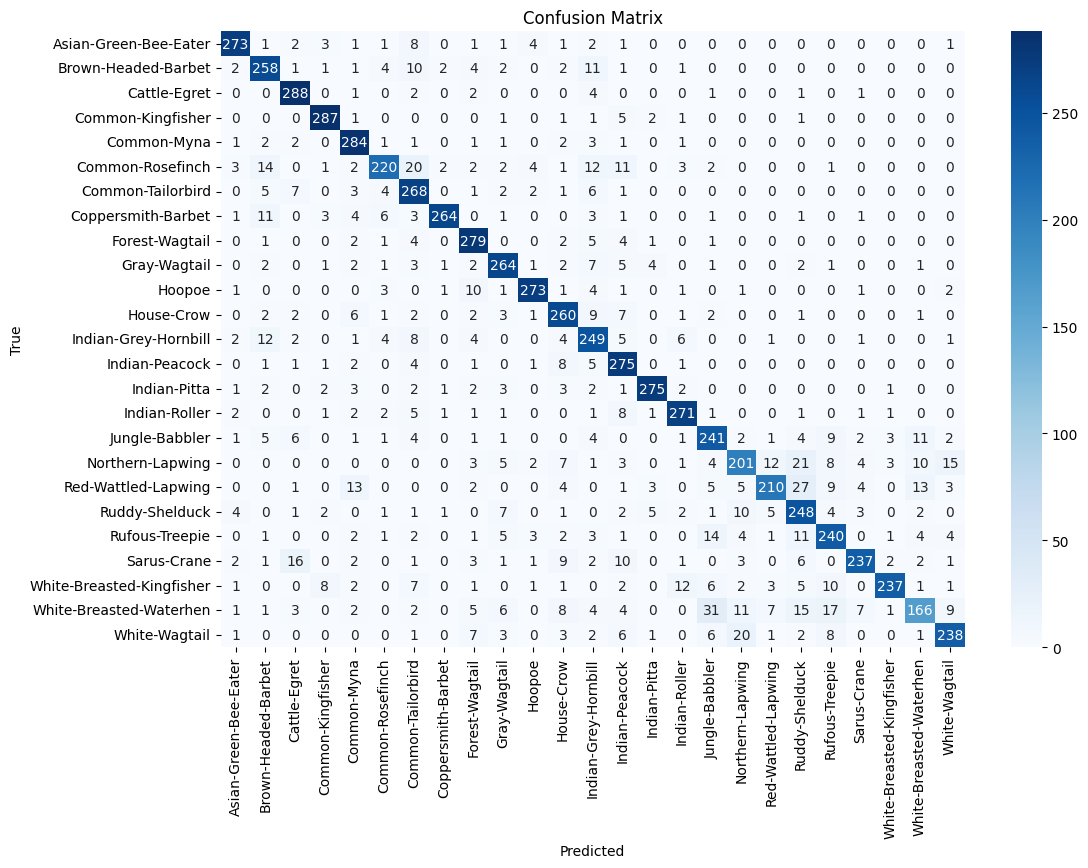

Classification Report:
                           precision    recall  f1-score   support

    Asian-Green-Bee-Eater       0.92      0.91      0.92       300
      Brown-Headed-Barbet       0.81      0.86      0.83       300
             Cattle-Egret       0.87      0.96      0.91       300
        Common-Kingfisher       0.93      0.96      0.94       300
              Common-Myna       0.84      0.95      0.89       300
         Common-Rosefinch       0.88      0.73      0.80       300
        Common-Tailorbird       0.75      0.89      0.81       300
       Coppersmith-Barbet       0.97      0.88      0.92       300
           Forest-Wagtail       0.83      0.93      0.88       300
             Gray-Wagtail       0.85      0.88      0.87       300
                   Hoopoe       0.93      0.91      0.92       300
               House-Crow       0.80      0.87      0.83       300
     Indian-Grey-Hornbill       0.73      0.83      0.78       300
           Indian-Peacock       0.77  

In [2]:
# !pip install seaborn

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Updated test function to include confusion matrix and classification report
def test_model(model, test_loader, class_names):
    model.eval()
    y_true = []
    y_pred = []
    y_probs = []
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Get probabilities
            _, predicted = torch.max(outputs.data, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())  # Collect probabilities
            total_loss += criterion(outputs, labels).item()

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_true, y_probs, multi_class='ovr')
    logloss = log_loss(y_true, y_probs)

    # Print metrics
    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'Test Precision: {precision:.2f}')
    print(f'Test Recall: {recall:.2f}')
    print(f'Test F1 Score: {f1:.2f}')
    print(f'Test ROC-AUC: {roc_auc:.2f}')
    print(f'Test Log Loss: {logloss:.2f}')
    
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Print classification report for each class
    report = classification_report(y_true, y_pred, target_names=class_names)
    print('Classification Report:')
    print(report)

# Class names corresponding to your 25 classes
class_names = test_dataset.classes

# Run the testing function
test_model(model, test_loader, class_names)
